# MARL Training Demo – Actor-Critic on FJSP

This notebook runs a short training session of the simple actor-critic policy on the toy Brandimarte-style FJSP instance and visualizes learning curves and policy behaviour.

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np

# Ensure project root (containing `src/`) is on sys.path
project_root = Path().resolve()
if not (project_root / "src").is_dir():
    # If running with cwd==`notebooks/`, go one level up
    parent = project_root.parent
    if (parent / "src").is_dir():
        project_root = parent

if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.seed_utils import SeedConfig, set_global_seeds
from src.ac_training import TrainingConfig, run_training

# Global seed for notebook reproducibility
set_global_seeds(SeedConfig(base_seed=2026))

# Use project_root so this works whether you run from repo root or notebooks/


instance_path = project_root / "benchmarks" / "flexible jobshop" / "instances" / "Brandimarte1993" / "mk01.txt"

train_config = TrainingConfig(
    instance_path=instance_path,
    seed_config=SeedConfig(base_seed=2026),
    num_episodes=100,
    max_steps_per_episode=64,
    log_interval=20,
    device="cuda",
)
train_config

TrainingConfig(instance_path=WindowsPath('C:/Users/Kata/Desktop/Multi-agent jobshop/benchmarks/flexible jobshop/instances/Brandimarte1993/mk01.txt'), seed_config=SeedConfig(base_seed=2026, python_seed=None, numpy_seed=None, torch_seed=None), learning_rate=0.0003, gamma=0.99, entropy_coef=0.01, value_coef=0.5, max_grad_norm=1.0, num_episodes=100, max_steps_per_episode=64, log_interval=20, device='cuda', checkpoint_dir=WindowsPath('checkpoints'), checkpoint_prefix='ac_fjsp')

In [2]:
# Quick smoke test: run a single episode with the untrained policy via run_training on a tiny run
small_config = TrainingConfig(
    instance_path=instance_path,
    seed_config=SeedConfig(base_seed=2027),
    num_episodes=5,
    max_steps_per_episode=32,
    log_interval=5,
    device="cuda",
)
small_metrics = run_training(small_config)
small_metrics["episode_rewards"]

[Seeds] python=2027, numpy=2027, torch=2027
[Episode 1/5] Reward=0.00, Makespan=0.00, Len=32, Loss=-0.0250, ValueLoss=0.0069
[Episode 5/5] Reward=0.00, Makespan=0.00, Len=32, Loss=-0.0577, ValueLoss=0.0020


[0.0, 0.0, 0.0, 0.0, 0.0]

In [3]:
# Main training run (short)
metrics = run_training(train_config)

episode_rewards = np.array(metrics["episode_rewards"])  # negative makespan sums
episode_makespans = np.array(metrics["episode_makespans"])
losses = np.array(metrics["losses"])
value_losses = np.array(metrics["value_losses"])

episode_rewards[:5], episode_makespans[:5]

[Seeds] python=2026, numpy=2026, torch=2026
[Episode 1/100] Reward=-117.00, Makespan=117.00, Len=55, Loss=4187.3462, ValueLoss=8373.9297
[Episode 20/100] Reward=-117.00, Makespan=117.00, Len=55, Loss=4034.1274, ValueLoss=8067.6270
[Episode 40/100] Reward=-117.00, Makespan=117.00, Len=55, Loss=3691.3721, ValueLoss=7382.2896
[Episode 60/100] Reward=-119.00, Makespan=119.00, Len=55, Loss=3240.4688, ValueLoss=6479.6924
[Episode 80/100] Reward=-102.00, Makespan=102.00, Len=55, Loss=1646.3901, ValueLoss=3291.9539
[Episode 100/100] Reward=-106.00, Makespan=106.00, Len=55, Loss=1058.0948, ValueLoss=2115.6526


(array([-117., -117., -117., -117., -117.]),
 array([117., 117., 117., 117., 117.]))

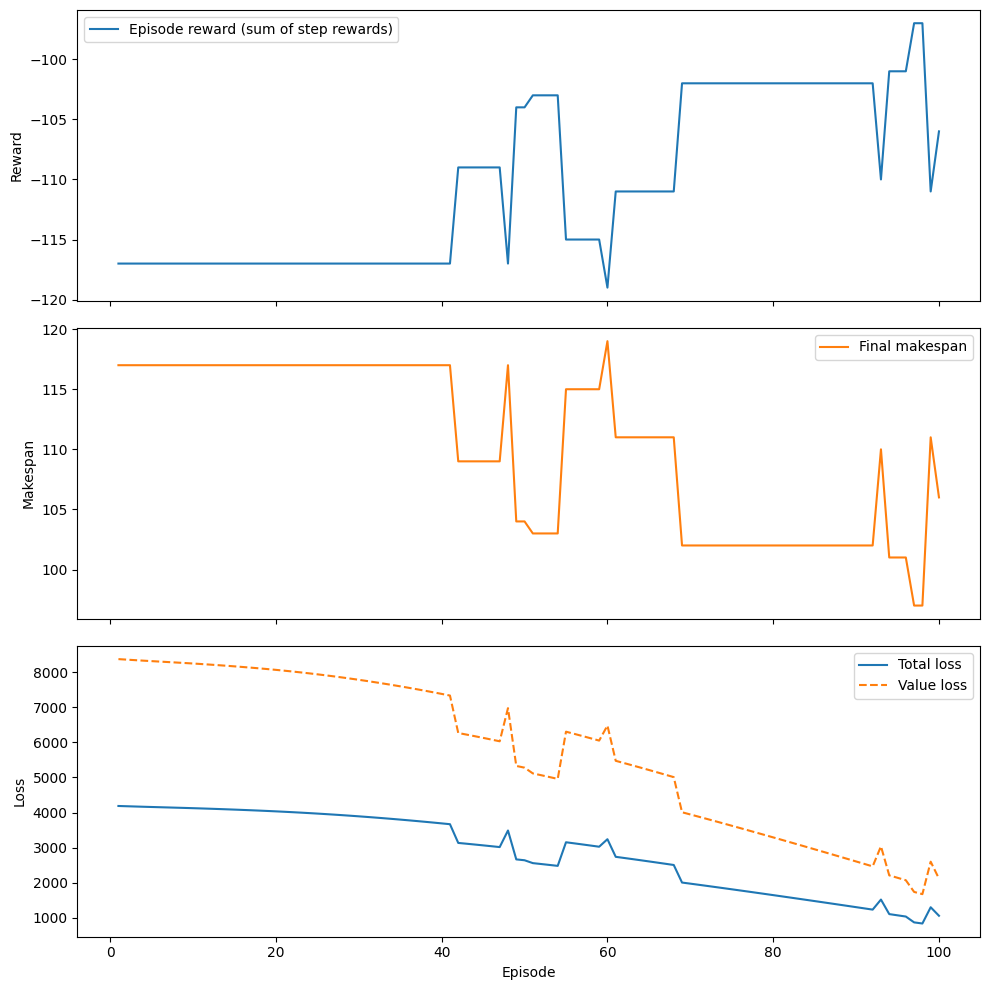

In [4]:
# Plot learning curves
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

episodes = np.arange(1, len(episode_rewards) + 1)

axes[0].plot(episodes, episode_rewards, label="Episode reward (sum of step rewards)")
axes[0].set_ylabel("Reward")
axes[0].legend()

axes[1].plot(episodes, episode_makespans, label="Final makespan", color="tab:orange")
axes[1].set_ylabel("Makespan")
axes[1].legend()

axes[2].plot(episodes, losses, label="Total loss")
axes[2].plot(episodes, value_losses, label="Value loss", linestyle="--")
axes[2].set_xlabel("Episode")
axes[2].set_ylabel("Loss")
axes[2].legend()

fig.tight_layout()
plt.show()

## Policy behaviour visualisation

Load the last checkpoint and run a few evaluation episodes with a deterministic policy to visualise schedules.

In [5]:
import torch

from src.fjsp_env import FJSPEnv, FJSPEnvConfig
from src.graph_builder import build_graph_from_env_state
from src.marl_policy import FJSPActorCritic

# Load last checkpoint from training run above
ckpt_path = train_config.checkpoint_dir / f"{train_config.checkpoint_prefix}_ep{train_config.num_episodes}.pt"
checkpoint = torch.load(ckpt_path, map_location="cpu", weights_only=False)

policy_eval = FJSPActorCritic()
policy_eval.load_state_dict(checkpoint["model_state_dict"])
policy_eval.eval()

env_cfg = FJSPEnvConfig(instance_path=instance_path, seed_config=SeedConfig(base_seed=3030))
env = FJSPEnv(env_cfg)

def run_eval_episode(env: FJSPEnv, policy: FJSPActorCritic):
    obs = env.reset()
    done = False
    step = 0
    trajectory = []

    while not done and step < 64:
        assert env._step_jobs is not None
        assert env._step_machines is not None

        graph = build_graph_from_env_state(env._step_jobs, env._step_machines)
        feasible_actions = obs["feasible_actions"]

        out = policy.get_action_and_value(graph, feasible_actions, deterministic=True)
        action_idx, logits, value = out

        obs, reward, done, info = env.step(action_idx)
        trajectory.append((step, feasible_actions, action_idx, reward, done))
        step += 1

    schedule = env.last_schedule
    makespan = env.last_makespan
    return trajectory, schedule, makespan

traj, schedule, makespan = run_eval_episode(env, policy_eval)
len(traj), makespan

(55, 119.0)

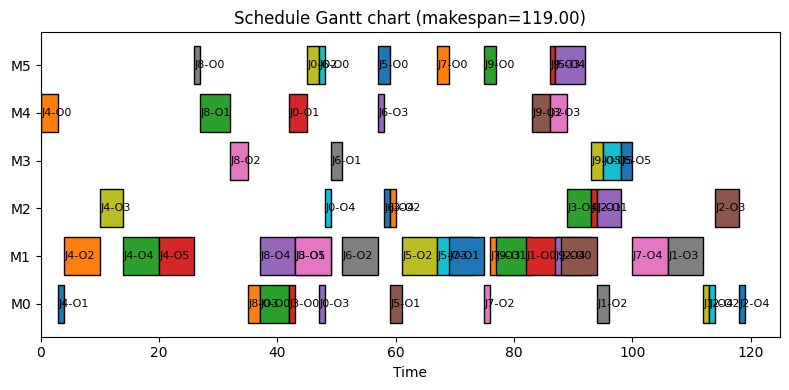

In [6]:
# Simple Gantt-like plot of the resulting schedule
fig, ax = plt.subplots(figsize=(8, 4))

machine_ids = sorted(schedule.keys())
yticks = []
yticklabels = []

for i, m_id in enumerate(machine_ids):
    ops = schedule[m_id]
    yticks.append(i)
    y = i
    yticklabels.append(f"M{m_id}")
    for (job_id, op_idx, start, end) in ops:
        ax.barh(y, end - start, left=start, edgecolor="black")
        ax.text(start + 0.1, y, f"J{job_id}-O{op_idx}", va="center", ha="left", fontsize=8)

ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_xlabel("Time")
ax.set_title(f"Schedule Gantt chart (makespan={makespan:.2f})")
fig.tight_layout()
plt.show()

In [7]:
from src.fjsp_env import FJSPEnv, FJSPEnvConfig
from src.seed_utils import SeedConfig
from typing import List, Tuple, Dict, Any
import numpy as np

def run_greedy_earliest_machine_episode(
    instance_path: Path,
    seed_config: SeedConfig,
    max_steps: int = 64,
) -> Tuple[float, int, Dict[int, Any]]:
    """Deterministic baseline: always pick the feasible action whose machine
    becomes available earliest (ties broken by lower machine id)."""
    env_cfg = FJSPEnvConfig(instance_path=instance_path, seed_config=seed_config)
    env = FJSPEnv(env_cfg)

    obs = env.reset()
    done = False
    step = 0

    while not done and step < max_steps:
        assert env._step_jobs is not None
        assert env._step_machines is not None

        feasible = obs["feasible_actions"]
        assert feasible, "Greedy baseline: no feasible actions."

        machines = env._step_machines

        # Choose action with smallest machine available_at (tie: smaller machine_id)
        best_idx = min(
            range(len(feasible)),
            key=lambda i: (float(machines[feasible[i][2]]["available_at"]), feasible[i][2]),
        )

        obs, reward, done, info = env.step(best_idx)
        step += 1

    assert env.last_makespan is not None, "Greedy baseline: makespan not set."
    return float(env.last_makespan), step, env.last_schedule


def evaluate_greedy_earliest_machine(
    instance_path: Path,
    base_seed: int = 5000,
    num_episodes: int = 20,
    max_steps: int = 64,
) -> Dict[str, Any]:
    makespans: List[float] = []
    for k in range(num_episodes):
        seed_cfg = SeedConfig(base_seed=base_seed + k)
        ms, steps, _ = run_greedy_earliest_machine_episode(
            instance_path=instance_path,
            seed_config=seed_cfg,
            max_steps=max_steps,
        )
        makespans.append(ms)

    arr = np.array(makespans, dtype=float)
    return {
        "makespans": makespans,
        "mean_makespan": float(arr.mean()),
        "std_makespan": float(arr.std()),
        "best_makespan": float(arr.min()),
        "worst_makespan": float(arr.max()),
    }

greedy_stats = evaluate_greedy_earliest_machine(instance_path, base_seed=6000, num_episodes=20)
greedy_stats

{'makespans': [80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0],
 'mean_makespan': 80.0,
 'std_makespan': 0.0,
 'best_makespan': 80.0,
 'worst_makespan': 80.0}

In [8]:
learned_makespan = float(makespan)

print("Greedy earliest-machine baseline:")
print(f"  mean makespan:  {greedy_stats['mean_makespan']:.2f}")
print(f"  std makespan:   {greedy_stats['std_makespan']:.2f}")
print(f"  best makespan:  {greedy_stats['best_makespan']:.2f}")
print(f"  worst makespan: {greedy_stats['worst_makespan']:.2f}")
print()
print("Learned actor-critic policy (deterministic eval):")
print(f"  makespan:       {learned_makespan:.2f}")       

Greedy earliest-machine baseline:
  mean makespan:  80.00
  std makespan:   0.00
  best makespan:  80.00
  worst makespan: 80.00

Learned actor-critic policy (deterministic eval):
  makespan:       119.00


In [12]:
from src.ppo_training import PPOConfig, run_ppo_training

ppo_config = PPOConfig(
    instance_path=instance_path,
    seed_config=SeedConfig(base_seed=21000),
    num_epochs=100,           # keep small so it runs quickly
    episodes_per_epoch=4,
    max_steps_per_episode=64,
    ppo_update_iters=4,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

ppo_metrics, ppo_policy = run_ppo_training(ppo_config)

epoch_losses = np.array(ppo_metrics["epoch_losses"])
epoch_value_losses = np.array(ppo_metrics["epoch_value_losses"])
epoch_mean_makespans = np.array(ppo_metrics["epoch_mean_makespans"])

epoch_losses[:5], epoch_mean_makespans[:5]

[PPO Epoch 1/100] MeanMakespan=122.00, Loss=1166.4750, ValueLoss=2333.0030
[PPO Epoch 10/100] MeanMakespan=122.00, Loss=1105.7058, ValueLoss=2211.4904
[PPO Epoch 20/100] MeanMakespan=89.00, Loss=426.1212, ValueLoss=852.3179
[PPO Epoch 30/100] MeanMakespan=89.00, Loss=180.6919, ValueLoss=361.4577
[PPO Epoch 40/100] MeanMakespan=122.00, Loss=155.6457, ValueLoss=311.3857
[PPO Epoch 50/100] MeanMakespan=99.00, Loss=69.9175, ValueLoss=139.8546
[PPO Epoch 60/100] MeanMakespan=105.00, Loss=54.2769, ValueLoss=108.6116
[PPO Epoch 70/100] MeanMakespan=87.00, Loss=28.8379, ValueLoss=57.7385
[PPO Epoch 80/100] MeanMakespan=93.00, Loss=30.0622, ValueLoss=60.1149
[PPO Epoch 90/100] MeanMakespan=81.00, Loss=13.7065, ValueLoss=27.4453
[PPO Epoch 100/100] MeanMakespan=115.00, Loss=54.3132, ValueLoss=108.6698


(array([1166.47503662, 1161.73828125, 1157.27914429, 1152.89068604,
        1147.52960205]),
 array([122., 122., 122., 122., 122.]))

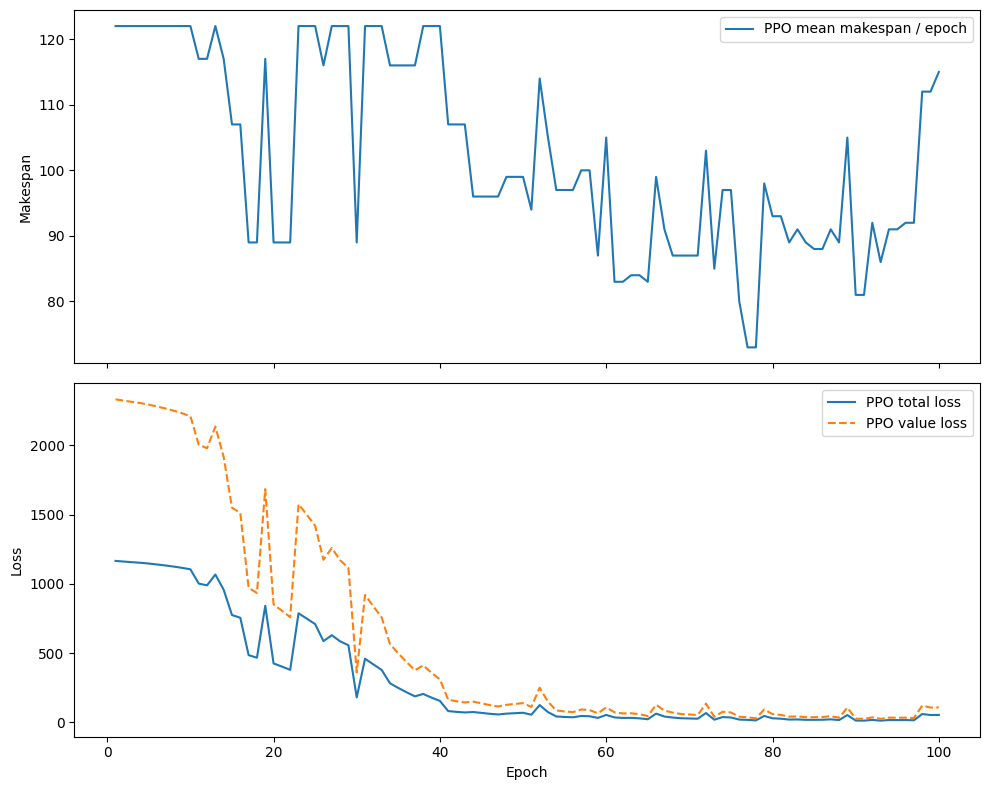

In [13]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

epochs = np.arange(1, len(epoch_losses) + 1)

axes[0].plot(epochs, epoch_mean_makespans, label="PPO mean makespan / epoch")
axes[0].set_ylabel("Makespan")
axes[0].legend()

axes[1].plot(epochs, epoch_losses, label="PPO total loss")
axes[1].plot(epochs, epoch_value_losses, label="PPO value loss", linestyle="--")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()

fig.tight_layout()
plt.show()

In [14]:
# Evaluate PPO policy deterministically (uses ppo_policy returned from run_ppo_training above)
env_ppo = FJSPEnv(FJSPEnvConfig(instance_path=instance_path, seed_config=SeedConfig(base_seed=33000)))
traj_ppo, schedule_ppo, makespan_ppo = run_eval_episode(env_ppo, ppo_policy)

print("Greedy earliest-machine baseline:")
print(f"  mean makespan:  {greedy_stats['mean_makespan']:.2f}")
print(f"  std makespan:   {greedy_stats['std_makespan']:.2f}")
print(f"  best makespan:  {greedy_stats['best_makespan']:.2f}")
print(f"  worst makespan: {greedy_stats['worst_makespan']:.2f}")
print()
print("PPO policy (deterministic eval on one episode):")
print(f"  makespan:       {float(makespan_ppo):.2f}")

Greedy earliest-machine baseline:
  mean makespan:  80.00
  std makespan:   0.00
  best makespan:  80.00
  worst makespan: 80.00

PPO policy (deterministic eval on one episode):
  makespan:       78.00
